# Audio Data Pre-Processing Analysis
- Developed by Marcelo Rovai
- Audio Capture from the post: ["Direct access to your webcam and microphone inside Google Colab notebook"](https://ricardodeazambuja.com/deep_learning/2019/03/09/audio_and_video_google_colab/)

[![Open In Colab <](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mjrovai/Arduino_Nicla_Vision/blob/main/KWS/Audio_Data_Analysis.ipynb)

### Install the Libraries

In [2]:
from IPython.display import HTML, Audio
from base64 import b64decode
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
import scipy.fftpack as fft
from scipy.fftpack import dct
from scipy.signal import spectrogram
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
import librosa
import soundfile as sf

### Define audio functions

In [3]:
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

In [4]:
def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

## Define the Plot functions

In [5]:
def plot_time(audio, figsize=(5,3), title=''):
    plt.figure(figsize=figsize)
    plt.plot(audio, alpha=0.5, label='audio')
    plt.grid(True)
    plt.title(title+' Sample - Time Domain')
    plt.xlabel('time')
    plt.ylabel('amplitude')
    plt.show()

In [6]:
def fft(data, sample_rate, figsize=(15,4),title = ''):

    N = sample_rate
    # Compute FFT
    yf = scipy.fftpack.fft(data)

    # Generate frequency bins
    xf = np.linspace(0.0, N//2, N//2)

    # Find the index of the maximum amplitude and its corresponding frequency
    start_bin = int(20 * (N // 2) / (N // 2))  # Corresponding bin for 20 Hz
    max_amplitude_idx = np.argmax(2.0/N * np.abs(yf[start_bin:N//2]))
    max_amplitude_frequency = xf[start_bin:][max_amplitude_idx]

    # Plot FFT (skipping the first 20 bins to start from 20 Hz)
    plt.figure(figsize=figsize)
    start_bin = int(20 * (N // 2) / (N // 2))  # Corresponding bin for 20 Hz
    plt.semilogx(xf[start_bin:], 2.0/N * np.abs(yf[start_bin:N//2]))

    # Add a point and label for the frequency with the maximum amplitude
    plt.scatter(max_amplitude_frequency, 2.0/N * np.abs(yf[start_bin:][max_amplitude_idx]), color='red')
    plt.annotate(f'Max Amp. @ {max_amplitude_frequency:.2f} Hz',
                 (max_amplitude_frequency, 2.0/N * np.abs(yf[start_bin:][max_amplitude_idx])),
                 textcoords="offset points",
                 xytext=(10,-10),
                 ha='left')

   # plt.semilogx(2.0/N * np.abs(yf[20:N//2]))
    plt.xlabel('frequency [Hz]')
    plt.ylabel('amp')
    plt.grid(True)
    plt.title(title+' sample - Frequency Components')
    return yf, max_amplitude_frequency
    plt.show()

In [7]:
def plot_spectogram(audio, sample_rate, figsize=(10,5), title=''):
    epsilon = 1e-10 # Small constant to avoid log10(0)
    frequencies, times, Sxx = spectrogram(audio, sample_rate)
    plt.figure(figsize=figsize)
    plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx + epsilon), shading='gouraud')
    plt.title(title+' Sample - Spectogram')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Intensity [dB]')
    plt.show()

In [8]:
def calc_plot_mfcc (audio, sample_rate, n_mfcc=13, figsize=(10,5), title=''):

    # Calculate MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)

    # # Plotting the MFCCs
    plt.figure(figsize=figsize)
    librosa.display.specshow(mfccs,
                             x_axis='time',
                             sr=sample_rate,
                             cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.ylabel('MFCC')
    plt.xlabel('time')
    plt.ylabel('MFCC Coefficients')
    plt.yticks(np.arange(0, 13, 1), [str(i+1) for i in range(13)])
    plt.title(title +' - Mel-frequency cepstral coefficients (MFCC)')
    plt.tight_layout()
    plt.show()

## Record and Play a sound sample

In [9]:
yes, sample_rate = get_audio()

NameError: name 'eval_js' is not defined

In [ ]:
no, sample_rate = get_audio()

In [ ]:
yes.shape, no.shape

In [ ]:
sample_rate

48000

## Crop 1-second of data

In [ ]:
yes = yes[:sample_rate]
no = no[:sample_rate]

## Save samples

In [ ]:
sf.write('yes.wav', yes, sample_rate)
sf.write('no.wav', no, sample_rate)

## Load and Plot the samples

Load the saved audio files, resampled as 16KHz
> Note that the sample_rate of captured audio data is always 48KHz. We used Librosa to resample it to 16KHz

In [11]:
# Load audio file
no_rain, sample_rate = librosa.load("Audios/No.wav", sr=16000, duration=1.0)

In [12]:
no_rain.shape, sample_rate

((16000,), 16000)

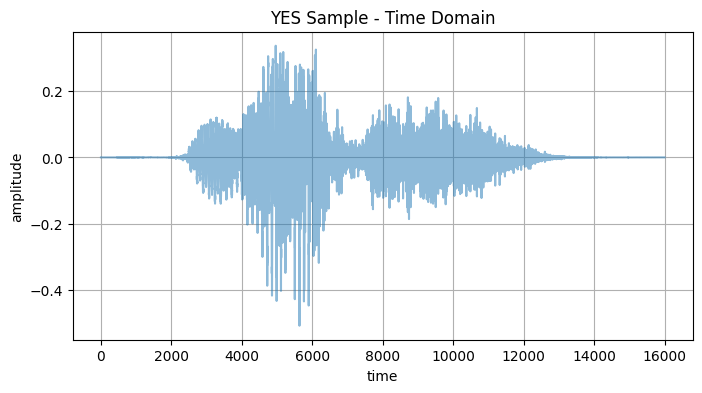

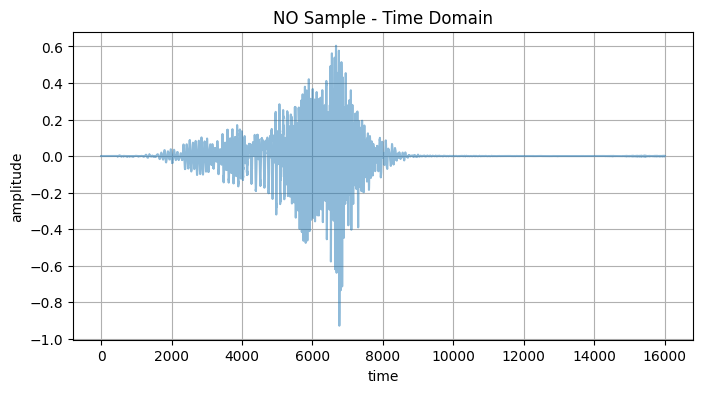

In [ ]:
plot_time(yes, figsize = (8,4), title='YES')
plot_time(no,  figsize = (8,4), title='NO')

## Calulate and plot the FFT of samples

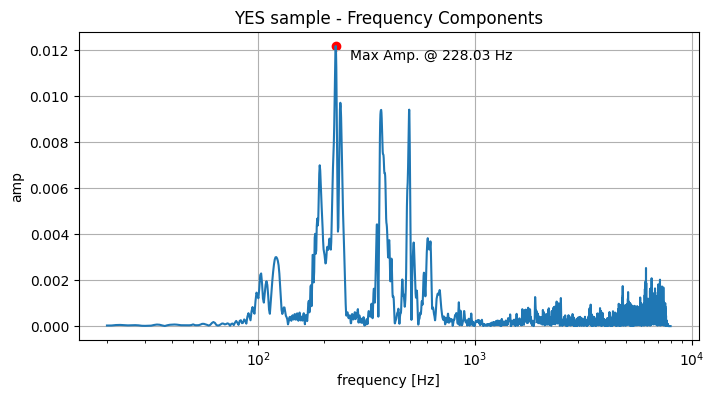

In [ ]:
yf_yes, max_amp_freq_yes = fft(yes, sample_rate, figsize = (8,4), title = 'YES')

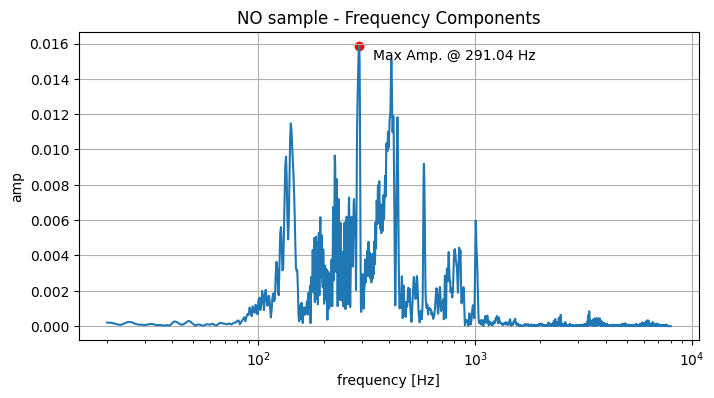

In [ ]:
yf_no, max_amp_freq_no = fft(no, sample_rate, figsize = (8,4), title = 'NO')

## Calculate and Plot spectograms

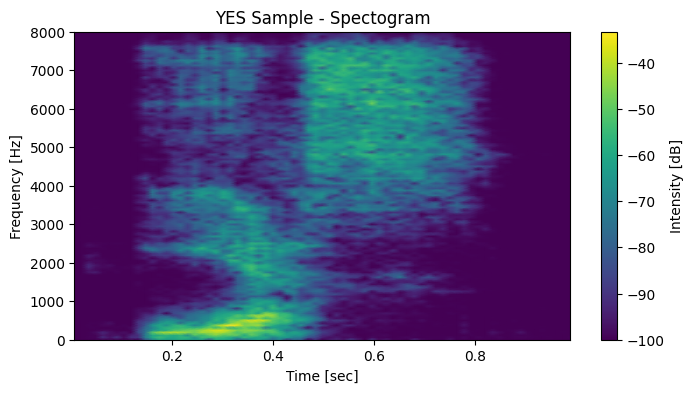

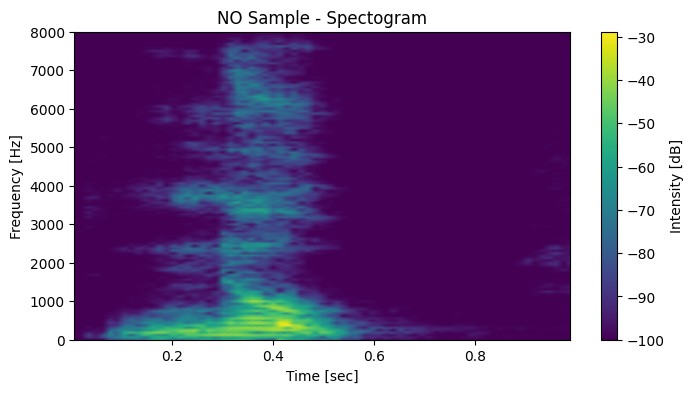

In [ ]:
plot_spectogram(yes, sample_rate, figsize = (8,4), title='YES')
plot_spectogram(no, sample_rate, figsize = (8,4), title='NO')

## Calculate and Plot MFCC

Librosa function is designed to handle the entire MFCC extraction process starting from the raw audio signal.

When you pass the raw audio signal to `librosa.feature.mfcc`, the function internally performs several steps including:

1. Framing the signal into overlapping frames.
2. Applying a window function to each frame.
3. Calculating the FFT to convert each frame to the frequency domain.
4. Applying Mel filter banks to the frequency spectra.
5. Taking the logarithm of the Mel frequencies.
6. Performing the Discrete Cosine Transform (DCT).


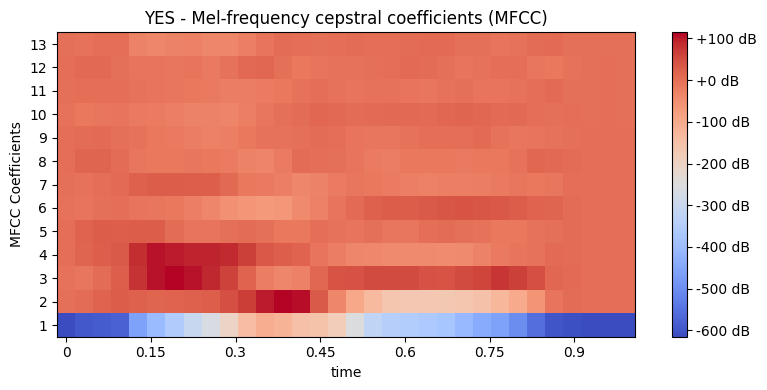

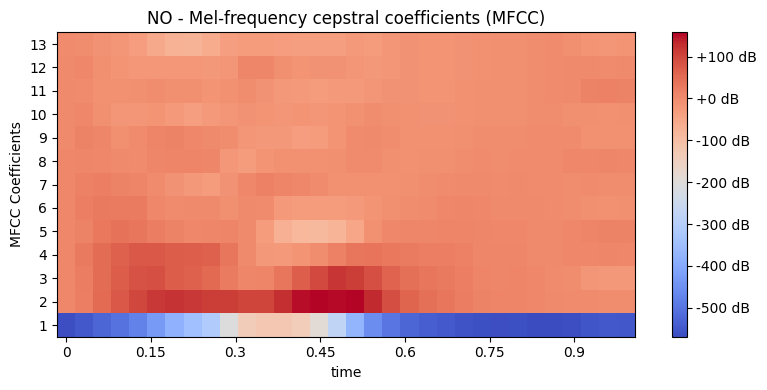

In [ ]:
calc_plot_mfcc (yes, sample_rate, n_mfcc=13, figsize = (8,4), title='YES')
calc_plot_mfcc (no, sample_rate, n_mfcc=13, figsize = (8,4), title='NO')

# Generating MFCC Features

## Using Librosa Display Library

[Text(0.5, 1.0, 'MFCC')]

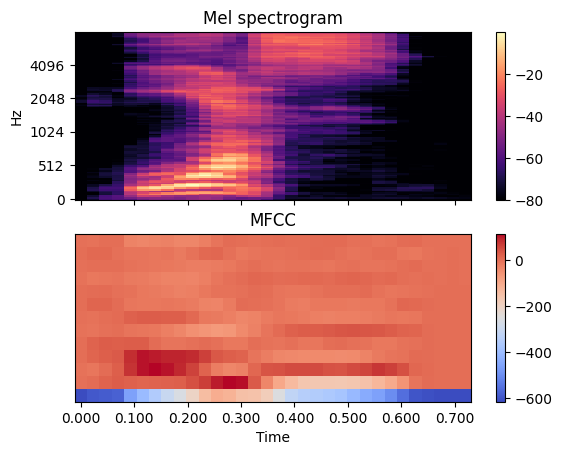

In [ ]:
S = librosa.feature.melspectrogram(y=yes,
                                   sr=sample_rate,
                                   n_mels=128,
                                   fmax=8000)

mfccs = librosa.feature.mfcc(y=yes,
                             sr=sample_rate,
                             n_mfcc=13)

fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(
    librosa.power_to_db(S, ref=np.max),
    x_axis='time', y_axis='mel',
    fmax=8000,
    ax=ax[0])

fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogram')
ax[0].label_outer()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC')


## MFCC Calculation and plot using numpy and scipy libraries

**Reading the audio file**

In [20]:
audio = no_rain

**Pre-emphasis**: Apply a pre-emphasis filter to high-pass filter the audio signal:

In [21]:
alpha = 0.97
audio = np.append(audio[0], audio[1:] - alpha * audio[:-1])

**Framing**: Divide the signal into frames of 20 milliseconds with a stride of 20 milliseconds:

In [22]:
# Parameters
frame_size = 0.08  # frame size in seconds
frame_stride = 0.025  # frame stride in seconds

# Calculate frame length and frame step (convert from seconds to samples)
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))

# Calculate the total number of frames
num_frames = int(np.ceil(float(np.abs(len(audio) - frame_length)) / frame_step))

frame_length, frame_step, num_frames

(1280, 400, 37)

In [23]:
# Pad audio signal
pad_audio_length = num_frames * frame_step + frame_length
z = np.zeros((pad_audio_length - len(audio)))
pad_audio = np.append(audio, z)

In [24]:
pad_audio.shape

(16080,)

In [25]:
# Initialize the frames
indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_audio[indices.astype(np.int32, copy=False)]

In [37]:
frames.shape

(37, 1280)

**Windowing**: Apply a Hamming window to each frame:

In [ ]:
# Apply window function (Hamming)
frames *= np.hamming(frame_length)

In [39]:
frames[10].shape

(1280,)

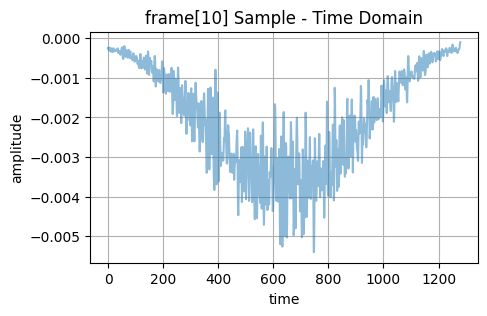

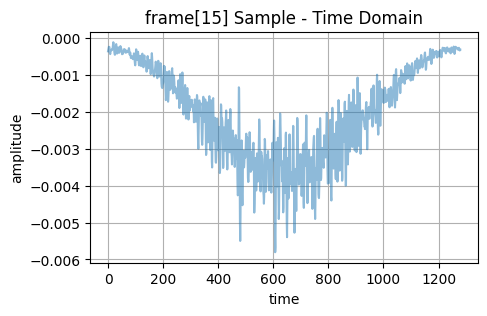

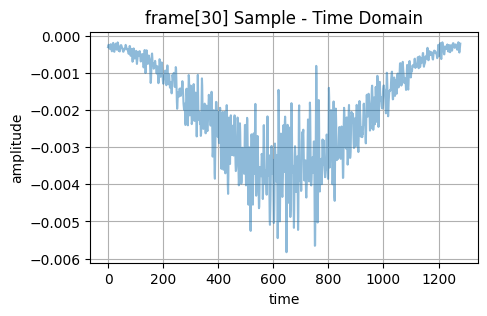

In [35]:
plot_time(frames[10], figsize = (5,3), title='frame[10]')
plot_time(frames[15], figsize = (5,3), title='frame[15]')
plot_time(frames[30], figsize = (5,3), title='frame[30]')

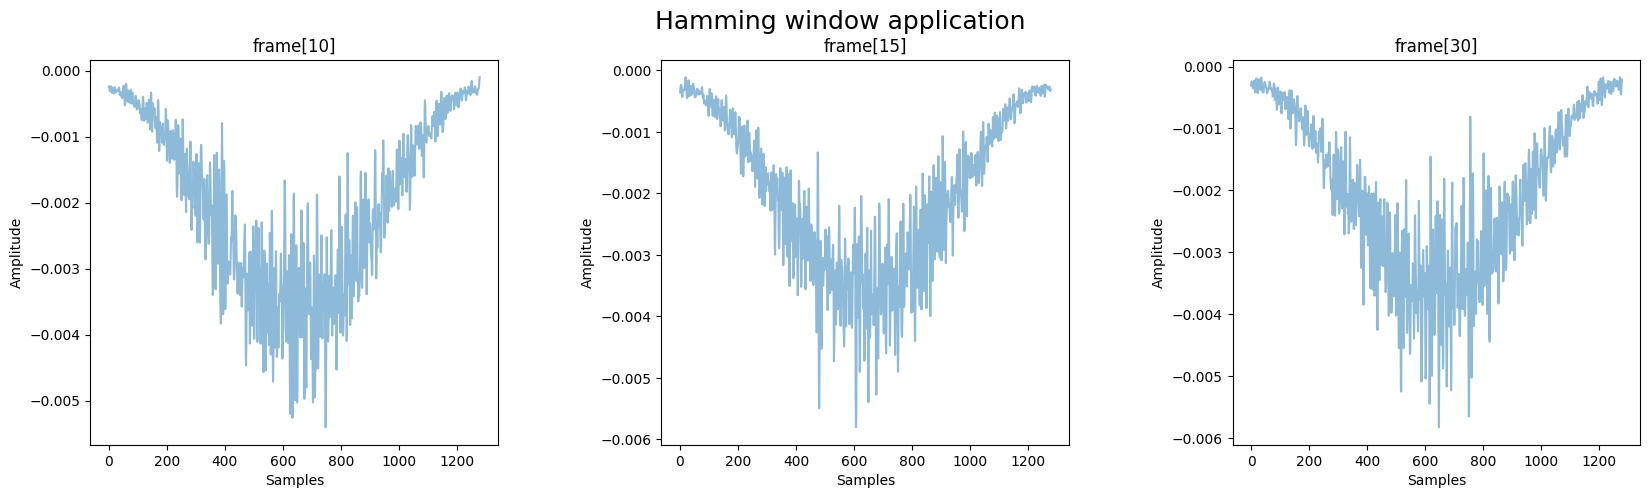

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.subplots_adjust(hspace=0.8, wspace=0.4)
fig.suptitle('Hamming window application', fontsize=18)

axs[0].plot(frames[10], alpha=0.5, label='Frame 10')
axs[0].set_title('frame[10]')

axs[1].plot(frames[15], alpha=0.5, label='Frame 15')
axs[1].set_title('frame[15]')

axs[2].plot(frames[30], alpha=0.5, label='Frame 30')
axs[2].set_title('frame[30]')

for ax in axs.flat:
    ax.set(xlabel='Samples', ylabel='Amplitude')

plt.show()


**Fast Fourier Transform (FFT)**: Perform FFT to convert the frames to frequency domain:

In [ ]:
# Perform FFT and calculate power spectrum
NFFT = 512
mag_frames = np.absolute(fft.fft(frames, NFFT))
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

In [ ]:
mag_frames.shape, pow_frames.shape

((49, 512), (49, 512))

We should take only up to `(NFFT/2) + 1` elements after the FFT, as those are the unique frequency components for real-valued signals. And also update the pow_frames calculation.

In [ ]:
mag_frames = mag_frames[:, :NFFT//2 + 1]
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

In [ ]:
mag_frames.shape, pow_frames.shape

((49, 257), (49, 257))

In [ ]:
def plot_frame_fft(data, figsize=(5,3), title=''):
    plt.figure(figsize=figsize)
    plt.plot(data)
    plt.xlabel('FFT Lenght')
    plt.ylabel('power')
    plt.grid(True)
    plt.title(title+' sample - Frequency Components')
    plt.show()

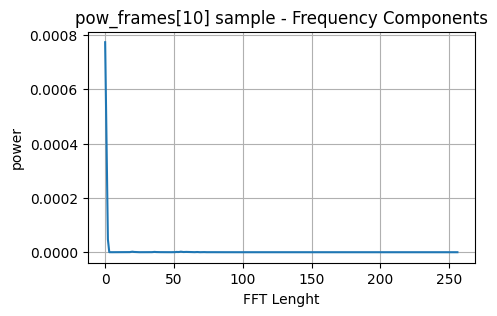

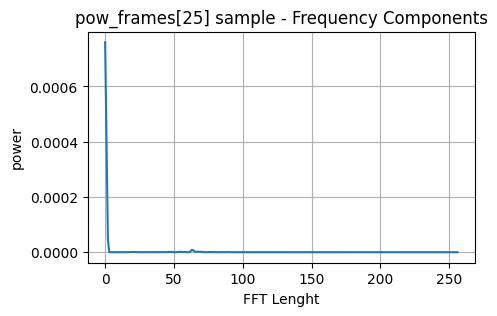

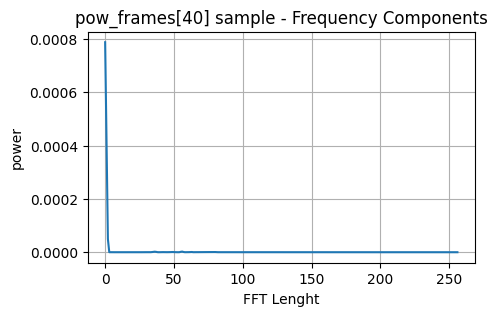

In [ ]:
plot_frame_fft(pow_frames[10], title = 'pow_frames[10]')
plot_frame_fft(pow_frames[25], title = 'pow_frames[25]')
plot_frame_fft(pow_frames[40], title = 'pow_frames[40]')

**Mel Filter Banks**: The frequency domain is then mapped to the Mel scale, which approximates the response of the human ear to different frequencies.

By setting low_freq_mel to the Mel equivalent of low_freq_cut (for ex. 80 Hz), we ensure that the lowest band edge of your Mel filter bank starts at that freq.

In [ ]:
low_freq_cut = 80
low_freq_mel = 2595 * np.log10(1 + low_freq_cut / 700.0)  # Convert Hz to Mel

In [ ]:
# Apply Mel filter banks
nfilt = 40
#low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])
    f_m = int(bin[m])
    f_m_plus = int(bin[m + 1])

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = 1 - (k - bin[m]) / (bin[m + 1] - bin[m])

filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
filter_banks = 20 * np.log10(filter_banks)  # dB

In [ ]:
filter_banks.shape

(49, 40)

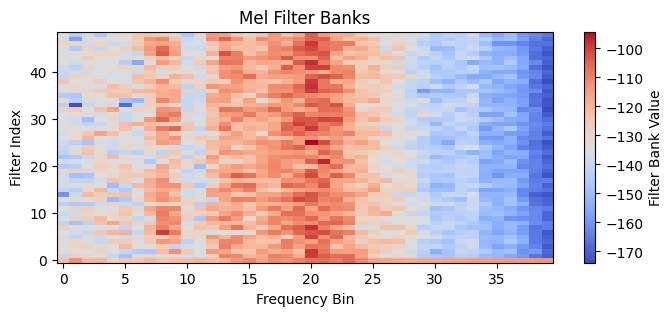

In [ ]:
# Plotting the filter bank matrix
plt.figure(figsize=(8,3))
plt.imshow(filter_banks, aspect='auto', cmap='coolwarm', origin='lower')
plt.colorbar(label='Filter Bank Value')
plt.xlabel('Frequency Bin')
plt.ylabel('Filter Index')
plt.title('Mel Filter Banks')
plt.show()

**Normalization**:

In [ ]:
noise_floor_dB = +1000000  # Replace with your specific noise floor level in dB

# Apply the noise floor
#ilter_banks = np.where(filter_banks < noise_floor_dB, noise_floor_dB, filter_banks)

# Optional: Normalize the Mel Filterbank Energies
mean = np.mean(filter_banks, axis=0)
std_dev = np.std(filter_banks, axis=0)
std_dev[std_dev == 0] = 1e-10

filter_banks -= mean
filter_banks /= std_dev

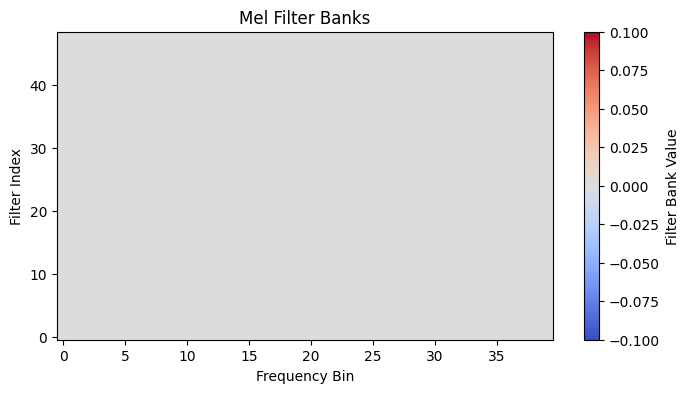

In [ ]:
# Plotting the filter bank matrix
plt.figure(figsize=(8,4))
plt.imshow(filter_banks, aspect='auto', cmap='coolwarm', origin='lower')
plt.colorbar(label='Filter Bank Value')
plt.xlabel('Frequency Bin')
plt.ylabel('Filter Index')
plt.title('Mel Filter Banks')
plt.show()

**Discrete Cosine Transform (DCT)**: The Mel frequencies are decorrelated and compressed, resulting in the final set of MFCCs.

In [ ]:
# Apply Discrete Cosine Transform (DCT)
num_ceps = 13
mfcc = dct(filter_banks, type=2, axis=-1, norm='ortho')[:, 1 : (num_ceps + 1)]  # Exclude 0th order coefficient (energy)

In [ ]:
mfcc.shape

(49, 13)

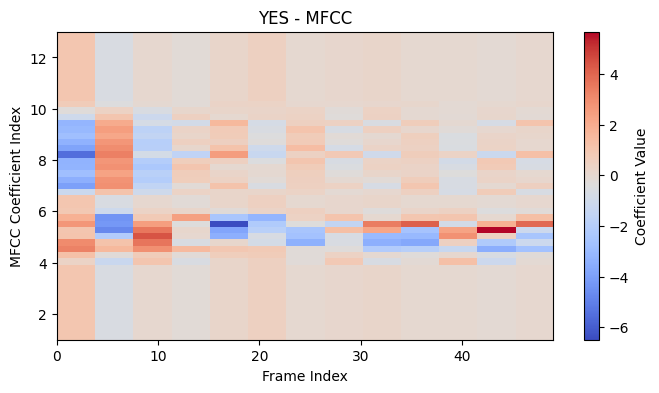

In [ ]:
# Plotting the MFCC
plt.figure(figsize=(8,4))
plt.imshow(mfcc, cmap='coolwarm', origin='lower', aspect='auto', extent=[0, 49, 1, 13])
plt.colorbar(label='Coefficient Value')
plt.xlabel('Frame Index')
plt.ylabel('MFCC Coefficient Index')
plt.title('YES - MFCC')
plt.show()


## Using a function to calc/plot mfcc

In [ ]:
 def calc_plot_mfcc_features(audio,
                             sample_rate,
                             alpha = 0.97,
                             NFFT=512,
                             low_freq_cut=80,
                             nfilt=40,
                             noise_floor_dB=-52,
                             frame_size=0.02,
                             frame_stride=0.02,
                             num_ceps=13,
                             figsize=(10, 5),
                             title= 'YES'
                             ):

    # Pre-emphasis
    audio = np.append(audio[0], audio[1:] - alpha * audio[:-1])

    # Calculate frame length and frame step (convert from seconds to samples)
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))

    # Calculate the total number of frames
    num_frames = int(np.ceil(float(np.abs(len(audio) - frame_length)) / frame_step))

    # Pad audio signal
    pad_audio_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_audio_length - len(audio)))
    pad_audio = np.append(audio, z)

    # Initialize the frames
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_audio[indices.astype(np.int32, copy=False)]

    # Apply window function (Hamming)
    frames *= np.hamming(frame_length)

    # Perform FFT and calculate power spectrum
    mag_frames = np.absolute(fft.fft(frames, NFFT))
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    # Take only up to (NFFT/2) + 1 elements after the FFT,
    # as those are the unique frequency components for real-valued signals.
    mag_frames = mag_frames[:, :NFFT//2 + 1]
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    # By setting low_freq_mel to the Mel equivalent of low_freq_cut (for ex. 80 Hz),
    # we ensure that the lowest band edge of your Mel filter bank starts at that freq.
    low_freq_mel = 2595 * np.log10(1 + low_freq_cut / 700.0)  # Convert Hz to Mel

    # Apply Mel filter banks
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])
        f_m = int(bin[m])
        f_m_plus = int(bin[m + 1])

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = 1 - (k - bin[m]) / (bin[m + 1] - bin[m])

    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    filter_banks = 20 * np.log10(filter_banks)  # dB

    # Apply the noise floor
    filter_banks = np.where(filter_banks < noise_floor_dB, noise_floor_dB, filter_banks)

    # Normalize the Mel Filterbank Energies
    mean = np.mean(filter_banks, axis=0)
    std_dev = np.std(filter_banks, axis=0)
    std_dev[std_dev == 0] = 1e-10
    filter_banks -= mean
    filter_banks /= std_dev

    # Apply Discrete Cosine Transform (DCT)
    mfcc = dct(filter_banks,
            type=2,
            axis=-1,
            norm='ortho')[:, 1 : (num_ceps + 1)]  # Exclude 0th order coefficient (energy)

    # Plotting the filter bank matrix
    plt.figure(figsize=figsize)
    plt.imshow(filter_banks, aspect='auto', cmap='coolwarm', origin='lower')
    plt.colorbar(label='Filter Bank Value')
    plt.xlabel('Frequency Bin')
    plt.ylabel('Filter Index')
    plt.title(title+' - Mel Filter Banks')

    # Plotting the MFCC
    plt.figure(figsize=figsize)
    plt.imshow(mfcc, cmap='coolwarm', origin='lower', aspect='auto', extent=[0, 49, 1, 13])
    plt.colorbar(label='Coefficient Value')
    plt.xlabel('Frame Index')
    plt.ylabel('MFCC Coefficient Index')
    plt.title(title+' - MFCC')
    plt.show()


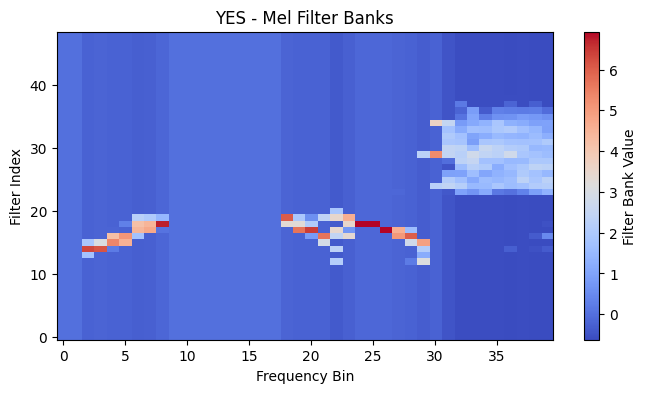

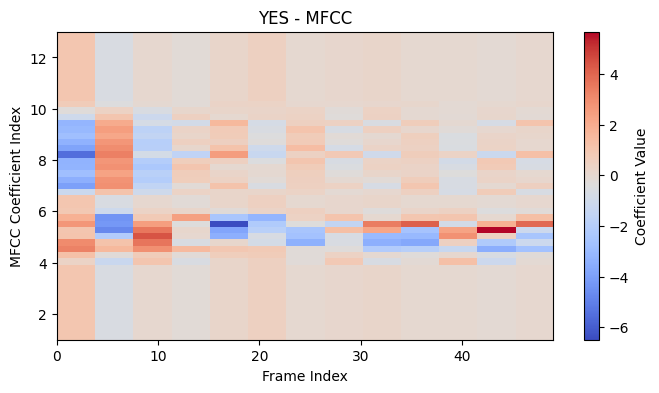

In [ ]:
calc_plot_mfcc_features(yes,
                        sample_rate,
                        alpha = 0.97,
                        NFFT=512,
                        low_freq_cut=80,
                        nfilt=40,
                        noise_floor_dB=-52,
                        frame_size=0.02,
                        frame_stride=0.02,
                        num_ceps = 13,
                        figsize = (8,4),
                        title= 'YES'
                             )

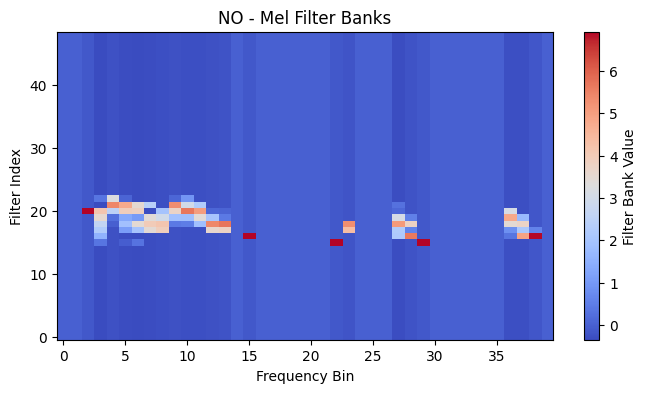

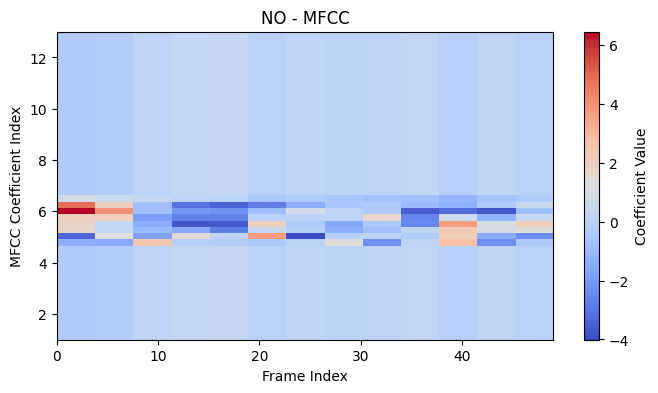

In [ ]:
calc_plot_mfcc_features(no,
                        sample_rate,
                        alpha = 0.97,
                        NFFT=512,
                        low_freq_cut=80,
                        nfilt=40,
                        noise_floor_dB=-52,
                        frame_size=0.02,
                        frame_stride=0.02,
                        num_ceps = 13,
                        figsize = (8,4),
                        title= 'NO'
                             )

# Support Image Generation

In [ ]:
def plot_signal_w_frames(audio, fs, frame_size = 0.020, frame_stride = 0.020, title = ''):

    t = np.linspace(0, 1, fs, endpoint=False)  # Time array

    # Define parameters for framing
    frame_length = int(round(frame_size * fs))
    frame_step = int(round(frame_stride * fs))
    num_frames = int(np.ceil(float(np.abs(len(audio) - frame_length)) / frame_step))

    # Create an array to hold frame boundaries
    frame_bounds = np.arange(0, len(audio), frame_step)

    # Plot the audio signal and frame boundaries
    plt.figure(figsize=(8,4))
    plt.plot(t, audio, label='Audio Signal')
    for boundary in frame_bounds:
        plt.axvline(boundary / fs, color='r', linestyle='--', linewidth=0.8)
    plt.title('1-second '+title+' Sample with Frame Boundaries')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()


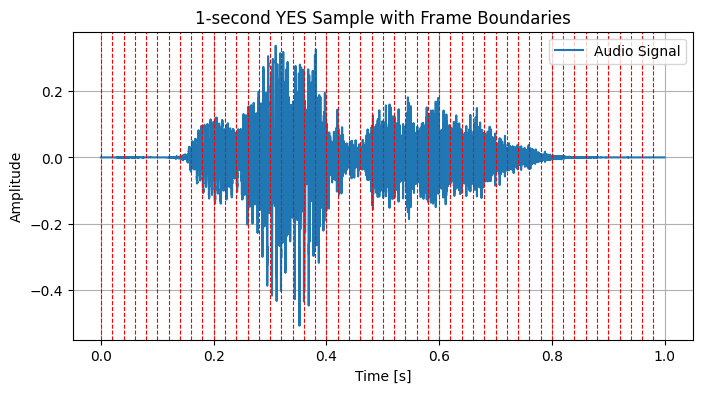

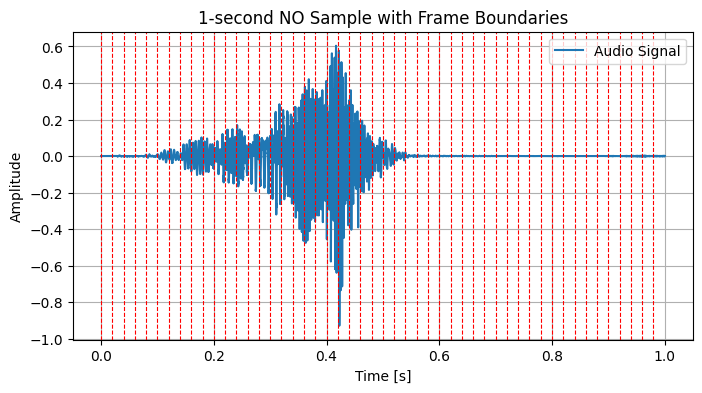

In [ ]:
plot_signal_w_frames(yes, sample_rate, title = 'YES')
plot_signal_w_frames(no, sample_rate, title = 'NO')